In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install eli5

     |████████████████████████████████| 112kB 3.5MB/s 


In [0]:
import os, time, json, re, copy, gc
import itertools, argparse, pickle, random
import os.path as osp

from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import nltk
from sklearn.utils import shuffle
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

import matplotlib
import matplotlib.pyplot as plt

# import eli5
# from eli5.lime import TextExplainer

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, Sampler

%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [0]:
USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [0]:
SEED = 2019
path = '/content/'

# Seed pytorch
def seed_torch(seed=SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

## Loading data, preprocessing and batchifying

### Download data

In [0]:
!mkdir /root/.kaggle
!cp /content/drive/My\ Drive/DL_projects/Data/kaggle.json /root/.kaggle/

In [6]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge -f train.csv

 19% 5.00M/26.3M [00:00<00:00, 43.3MB/s]
100% 26.3M/26.3M [00:00<00:00, 104MB/s] 


In [7]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge -f test.csv

 30% 7.00M/23.4M [00:00<00:00, 70.9MB/s]
100% 23.4M/23.4M [00:00<00:00, 115MB/s] 


In [8]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [9]:
!unzip test.csv.zip

Archive:  test.csv.zip
  inflating: test.csv                


In [0]:
!rm train.csv.zip test.csv.zip

In [0]:
!mv train.csv train_b.csv

In [16]:
!kaggle competitions download -c jigsaw-unintended-bias-in-toxicity-classification -f train.csv
!unzip train.csv.zip
!rm train.csv.zip

 99% 271M/273M [00:03<00:00, 74.7MB/s]
100% 273M/273M [00:03<00:00, 93.2MB/s]
Archive:  train.csv.zip
  inflating: train.csv               


In [0]:
!mv train.csv train_ub.csv

### Loading and preprocessing

In [0]:
vocab_size = 100000
max_len = 220

In [0]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
text_column = 'comment_text'

puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…',
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─',
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞',
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]
symbols_to_isolate = ''.join(puncts)
isolate_dict = {ord(c):f' {c} ' for c in symbols_to_isolate}

def clean_punc(x):
    x = str(x)
    x = x.translate(isolate_dict)
    return x

def clean_text(raw):
    return clean_punc(raw.lower()).strip()

In [0]:
def word_idx_map(raw_comments, vocab_size):
    """
    :return: word, index mapping
    """
    def build_vocab(sentences):
        """
        :param sentences: list of list of words
        :return: dictionary of words and their count
        """
        vocab = {}
        for sentence in sentences:
            for word in sentence:
                try:
                    vocab[word] += 1
                except KeyError:
                    vocab[word] = 1
        return vocab

    def most_common_vocab(vocab, k):
        """
        :param vocab: dictionary of words and their count
        :k: former k words to return
        :return: list of k most common words
        """
        sorted_vocab = sorted([(cnt,w) for w,cnt in vocab.items()])[::-1]
        return [(w,cnt) for cnt,w in sorted_vocab][:k]

    texts = [c.split() for c in raw_comments]
    word_freq = build_vocab(texts)
    vocab_freq = most_common_vocab(word_freq, vocab_size)
    idx_to_word = ['<pad>'] + [word for word, cnt in vocab_freq] + ['<unk>']
    word_to_idx = {word:idx for idx, word in enumerate(idx_to_word)}

    return word_to_idx, idx_to_word

def tokenize(comments, word_to_idx, maxlen):
    '''
    Tokenize and numerize the comment sequences
    Inputs:
    - comments: pandas series of comments
    - word_to_idx: word to index mapping
    - maxlen: max length of each sequence of tokens

    Returns:
    - tokens: list of sequences (also list of tokens with length maxlen)
              with length data_size
    '''

    def text_to_id(c, word_to_idx, maxlen):
        return [(lambda x: word_to_idx[x] if x in word_to_idx else word_to_idx['<unk>'])(w) \
                 for w in c.split()[-maxlen:]]

    return np.array([text_to_id(c, word_to_idx, maxlen) for c in comments])

In [0]:
def load_and_preproc():
    aug_df = pd.read_csv(path+'train_ub.csv')
    train_df = pd.read_csv(path+'train_b.csv')
    test_df = pd.read_csv(path+'test.csv')

    print('cleaning text...')
    t0 = time.time()
    aug_df[text_column] = aug_df[text_column].apply(clean_text)
    train_df[text_column] = train_df[text_column].apply(clean_text)
    test_df[text_column] = test_df[text_column].apply(clean_text)
    print('cleaning complete in {:.0f} seconds.'.format(time.time()-t0))

    y_train = train_df[label_cols].values.astype('float32')

    return train_df[text_column], aug_df[text_column], test_df[text_column], y_train

In [20]:
%%time
np.random.seed(SEED)
train_seq, aug_train_seq, x_test, train_tars = load_and_preproc()

cleaning text...
cleaning complete in 47 seconds.
CPU times: user 1min, sys: 1.6 s, total: 1min 1s
Wall time: 1min 1s


In [21]:
%%time
word_to_idx, idx_to_word = word_idx_map(train_seq.tolist()+aug_train_seq.tolist()+x_test.tolist(), vocab_size)
del aug_train_seq, x_test

CPU times: user 1min 3s, sys: 3.34 s, total: 1min 7s
Wall time: 1min 7s


### train/val split

In [0]:
def train_val_split(train_x, train_y):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    cv_indices = [(tr_idx, val_idx) for tr_idx, val_idx in kf.split(train_x, train_y)]
    return cv_indices

cv_indices = train_val_split(train_seq, train_tars[:,0])

In [0]:
trn_idx, val_idx = cv_indices[0]

x_train, x_val = train_seq[trn_idx], train_seq[val_idx]
y_train, y_val = train_tars[trn_idx], train_tars[val_idx]

In [24]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((127656,), (31915,), (127656, 6), (31915, 6))

In [0]:
del train_seq, train_tars

In [26]:
print('tokenizing...')
t0 = time.time()
x_val = tokenize(x_val, word_to_idx, max_len)
print('tokenizing complete in {:.0f} seconds.'.format(time.time()-t0))

tokenizing...
tokenizing complete in 1 seconds.


### data loader

In [0]:
# Prepare dataset and dataloader
class Toxic_comments(Dataset):

    def __init__(self, tokenized_comments, targets=None, split=None, maxlen=256):
        self.comments = tokenized_comments
        self.targets = targets
        self.split = split
        assert self.split in {'train', 'valid', 'test'}
        self.maxlen = maxlen

    def __getitem__(self, index):
        comment = self.comments[index]
        if self.targets is not None:
            target = self.targets[index]
            return comment, torch.FloatTensor(target)
        else:
            return comment

    def __len__(self):
        return len(self.comments)

    def get_lens(self):
        lengths = np.fromiter(
            ((min(self.maxlen, len(seq))) for seq in self.comments),
            dtype=np.int32)
        return lengths

    def collate_fn(self, batch):
        """
        Collate function for sequence bucketing
        Note: this need not be defined in this Class, can be standalone.

        :param batch: an iterable of N sets from __getitem__()
        :return: a tensor of comments, and targets
        """

        if self.split in ('train', 'valid'):
            comments, targets = zip(*batch)
        else:
            comments = batch

        lengths = [len(c) for c in comments]
        maxlen = max(lengths)
        padded_comments = []
        for i, c in enumerate(comments):
            padded_comments.append([0]*(maxlen - lengths[i])+c)

        if self.split in ('train', 'valid'):
            return torch.LongTensor(padded_comments), torch.stack(targets)
        else:
            return torch.LongTensor(padded_comments)


class BucketSampler(Sampler):

    def __init__(self, data_source, sort_lens, bucket_size=None, batch_size=1024, shuffle_data=True):
        super().__init__(data_source)
        self.shuffle = shuffle_data
        self.batch_size = batch_size
        self.sort_lens = sort_lens
        self.bucket_size = bucket_size if bucket_size is not None else len(sort_lens)
        self.weights = None

        if not shuffle_data:
            self.index = self.prepare_buckets()
        else:
            self.index = None

    def set_weights(self, weights):
        assert weights >= 0
        total = np.sum(weights)
        if total != 1:
            weights = weights / total
        self.weights = weights

    def __iter__(self):
        indices = None
        if self.weights is not None:
            total = len(self.sort_lens)
            indices = np.random.choice(total, (total,), p=self.weights)
        if self.shuffle:
            self.index = self.prepare_buckets(indices)
        return iter(self.index)

    def get_reverse_indexes(self):
        indexes = np.zeros((len(self.index),), dtype=np.int32)
        for i, j in enumerate(self.index):
            indexes[j] = i
        return indexes

    def __len__(self):
        return len(self.sort_lens)

    def prepare_buckets(self, indices=None):
        lengths = - self.sort_lens
        assert self.bucket_size % self.batch_size == 0 or self.bucket_size == len(lengths)

        if indices is None:
            if self.shuffle:
                indices = shuffle(np.arange(len(lengths), dtype=np.int32))
                lengths = lengths[indices]
            else:
                indices = np.arange(len(lengths), dtype=np.int32)

        #  bucket iterator
        def divide_chunks(l, n):
            if n == len(l):
                yield np.arange(len(l), dtype=np.int32), l
            else:
                # looping till length l
                for i in range(0, len(l), n):
                    data = l[i:i + n]
                    yield np.arange(i, i + len(data), dtype=np.int32), data

        new_indices = []
        extra_batch_idx = None
        for chunk_index, chunk in divide_chunks(lengths, self.bucket_size):
            # sort indices in bucket by descending order of length
            indices_sorted = chunk_index[np.argsort(chunk)]

            batch_idxes = []
            for _, batch_idx in divide_chunks(indices_sorted, self.batch_size):
                if len(batch_idx) == self.batch_size:
                    batch_idxes.append(batch_idx.tolist())
                else:
                    assert extra_batch_idx is None
                    assert batch_idx is not None
                    extra_batch_idx = batch_idx.tolist()

            # shuffling batches within buckets
            if self.shuffle:
                batch_idxes = shuffle(batch_idxes)
            for batch_idx in batch_idxes:
                new_indices.extend(batch_idx)

        if extra_batch_idx is not None:
            new_indices.extend(extra_batch_idx)

        if not self.shuffle:
            self.original_indices = np.argsort(indices_sorted).tolist()
        return indices[new_indices]


def prepare_loader(x, y=None, batch_size=1024, split=None):
    assert split in {'train', 'valid', 'test'}
    dataset = Toxic_comments(x, y, split, max_len)
    if split == 'train':
        sampler = BucketSampler(dataset, dataset.get_lens(),
                                bucket_size=batch_size*20, batch_size=batch_size)
        return DataLoader(dataset, batch_size=batch_size, sampler=sampler,
                          collate_fn=dataset.collate_fn)
    else:
        sampler = BucketSampler(dataset, dataset.get_lens(),
                                batch_size=batch_size, shuffle_data=False)
        return DataLoader(dataset, batch_size=batch_size, sampler=sampler,
                          collate_fn=dataset.collate_fn), sampler.original_indices

In [0]:
val_loader, val_original_indices = prepare_loader(x_val, y_val, split='valid')

## Load embeddings

In [0]:
def load_embeddings(path):
    with open(path,'rb') as f:
        emb_index = pickle.load(f)
    return emb_index

def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')

def get_embedding(embedding_file, word_to_idx, embedding_dim=300):
    # with open(embedding_file, encoding="utf8", errors='ignore') as f:
    #     embeddings_index = dict(get_coefs(*o.split(' ')) for o in f if len(o)>100)
    print(f'loading {embedding_file}')
    embeddings_index = load_embeddings(embedding_file)

    all_embs = np.stack([emb for emb in embeddings_index.values() if len(emb)==embedding_dim])
    emb_mean, emb_std = all_embs.mean(), all_embs.std()

    nb_words = len(word_to_idx)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_dim))
    for word, i in word_to_idx.items():
        if i > nb_words: break
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        embedding_vector = embeddings_index.get(word.upper())
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        embedding_vector = embeddings_index.get(word.title())
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
    return embedding_matrix

In [33]:
os.chdir('/content/drive/My Drive/DL_projects/nlp_toxic_comments')
os.listdir('../Data/wordvecs')

['glove.6B.50d.txt',
 'glove.6B.100d.txt',
 'GoogleNews-vectors-negative300',
 'glove.840B.300d',
 'paragram_300_sl999',
 'wiki-news-300d-1M',
 'crawl-300d-2M.pkl',
 'paragram_300_sl999.pkl',
 'glove.840B.300d.pkl',
 'wiki-news-300d-1M.pkl']

In [34]:
%%time
EMBEDDING_FILE = '../Data/wordvecs/crawl-300d-2M.pkl'
embed_mat = get_embedding(EMBEDDING_FILE, word_to_idx)

loading ../Data/wordvecs/crawl-300d-2M.pkl
CPU times: user 15.1 s, sys: 4.76 s, total: 19.8 s
Wall time: 33.6 s


In [35]:
embed_mat.shape

(100002, 300)

## Load model

In [0]:
class SpatialDropout(nn.Dropout2d):
    def forward(self, x):
        x = x.unsqueeze(-1)    # (N, T, M, 1)
        x = x.transpose(1,2)   # (N, M, T, 1)
        x = super(SpatialDropout, self).forward(x)  # (N, M, T, 1), some features are masked
        x = x.squeeze(-1)     # (N, M, T)
        x = x.transpose(1,2)   # (N, T, M)
        return x

class EmbeddingLayer(nn.Module):

    def __init__(self, vocab_size, embed_dim, embed_matrix):
        super(EmbeddingLayer, self).__init__()
        self.emb = nn.Embedding(vocab_size, embed_dim)
        self.emb.weight = nn.Parameter(torch.tensor(embed_matrix, dtype=torch.float32))
        self.emb_dropout = SpatialDropout(0.35)

    def forward(self, seq):
        emb = self.emb(seq)
        emb = self.emb_dropout(emb)
        return emb

class RecurrentNet(nn.Module):

    def __init__(self, embed_dim, hidden_dim):
        super(RecurrentNet, self).__init__()
        # Init layers
        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.gru = nn.GRU(hidden_dim*2, hidden_dim, bidirectional=True, batch_first=True)

        for mod in (self.lstm, self.gru):
            for name, param in mod.named_parameters():
                if 'weight_ih' in name:
                    nn.init.xavier_uniform_(param)
                if 'weight_hh' in name:
                    nn.init.orthogonal_(param)

    def forward(self, seq):
        o_lstm, _ = self.lstm(seq)
        o_gru, _ = self.gru(o_lstm)
        return o_gru

class CommentClassifier(nn.Module):

    def __init__(self, hidden_dim, output_dim):
        super(CommentClassifier, self).__init__()
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(hidden_dim*4, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, seq):
        avg_pool = torch.mean(seq, 1)
        max_pool, _ = torch.max(seq, 1)
        h_concat = torch.cat((avg_pool, max_pool), 1)
        h_concat = self.fc(self.dropout(h_concat))
        out = self.fc_out(h_concat)
        return out

class JigsawNet(nn.Module):

    def __init__(self, vocab_size, embed_dim, hidden_dim, embed_matrix):
        super(JigsawNet, self).__init__()
        # Init layers
        self.emb_layer = EmbeddingLayer(vocab_size, embed_dim, embed_matrix)
        self.rnns = RecurrentNet(embed_dim, hidden_dim)
        self.classifier = CommentClassifier(hidden_dim, 6)

    def forward(self, seq):
        emb = self.emb_layer(seq)
        o_rnn = self.rnns(emb)
        out = self.classifier(o_rnn)

        return out

In [37]:
def model_test():
    x = torch.zeros((32, max_len), dtype=torch.long)
    x = x.to(device)
    
    model = JigsawNet(*embed_mat.shape, 128, embed_mat)
    model = model.to(device)
    scores = model(x)
    print(scores.size())

model_test()

torch.Size([32, 6])


In [39]:
models = torch.load('biased_models.pt')
model = JigsawNet(*embed_mat.shape, 128, embed_mat)
model.load_state_dict(models['fold_0'])

<All keys matched successfully>

## Evaluation

In [0]:
def eval_model(model, data_loader, mode='test', target_only=True):
    assert mode in ('val', 'test')
    model.eval()
    test_scores = []
    with torch.no_grad():
        for x in data_loader:
            if mode=='val': x = x[0]
            x = x.to(device=device, dtype=torch.long)
            score = torch.sigmoid(model(x))
            test_scores.append(score.cpu().numpy())
    return np.concatenate(test_scores)

In [0]:
model = model.to(device)
val_scores = eval_model(model, val_loader, mode='val')[val_original_indices]

In [45]:
roc_auc_score(y_val, val_scores)

0.9906106660395867

## Visualization

In [0]:
l_dtype = torch.cuda.LongTensor
f_dtype = torch.cuda.FloatTensor

def preprocessing(string):
    return tokenize([clean_text(string)], word_to_idx, max_len)

# compute gradients
def compute_backprop(X, y, net, class_label):
    net.eval()
    scores = net(X)
    correct_scores = scores[:,class_label].squeeze() if y==1 else 1-scores.squeeze()
    loss = correct_scores.sum()
    loss.backward()

# forward propagation for inference
def get_preds(x, net, class_label):
    net.eval()
    logit = net(x)
    prob = torch.sigmoid(logit[:,class_label]).detach().cpu().numpy()
    return prob

# feature extractor
def extract_features(x, net):
    net.eval()
    return net.rnns(net.emb_layer(x)).detach()   # (N, T, H)

class Net_classifier(nn.Module):
    def forward(self, x): return copy.deepcopy(model.classifier)(x)

class GradCAM(nn.Module):
    def __init__(self):
        super(GradCAM, self).__init__()
        self.ap = nn.AdaptiveAvgPool1d(1)
    
    def forward(self, feature_maps, feature_grads):
        # features size: (1, T, H) -> (1, H, T)
        map_weights = self.ap(feature_grads.transpose(1,2))   # (1, H, 1)
        maps = torch.sum(map_weights * feature_maps.transpose(1,2), 1)   # (1, T)
        grad_cam = F.relu(maps.squeeze(0))
        return grad_cam   # (T,)

def normalize_cam(cam):
    cam = cam - cam.min()
    return cam / cam.max() if cam.max()>0 else cam

def return_grad_cam(feature_maps, class_label):
    # generate the grad-CAM
    classifier = Net_classifier()
    
    feature_maps = f_dtype(feature_maps)
    feature_maps.requires_grad_()

    compute_backprop(feature_maps, 1, classifier, class_label)
    gradCAM = GradCAM()
    cam = gradCAM(feature_maps, feature_maps.grad).detach().cpu().numpy()  # (T,)
    return normalize_cam(cam)

# CANNOT use CAM in this network
def return_cam(features, weights):  # (T, 2*H), (4*H,)
    # generate the class activation maps (CAMs)
    D = len(weights)
    cam_avg = weights[:int(D/2)].dot(features.T)  # (T,)
    cam_avg = normalize_cam(cam_avg)
    cam_max = weights[int(D/2):].dot(features.T)  # (T,)
    cam_max = normalize_cam(cam_max)
    return cam_avg, cam_max

def plot_cam(x, y, figsize=(8,4), title=None):
    fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True, figsize=figsize)
    
    extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2., 0, 1]
    
    if title is not None:
        ax1.set_title(title, color='w')
    
    ax1.imshow(y[None,:], cmap="hot", aspect="auto", extent=extent)
    ax1.set_yticks([])
    ax1.set_xlim(extent[0], extent[1])

    ax2.plot(x,y)
    ax2.set_xlabel('Word position')
    ax2.set_ylabel('Attentive intensity')
    # ax2.xaxis.label.set_color('w')
    # ax2.yaxis.label.set_color('w')
    ax2.tick_params(axis='x')
    ax2.tick_params(axis='y')
    # ax2.tick_params(axis='x', colors='w')
    # ax2.tick_params(axis='y', colors='w')

    plt.tight_layout()
    plt.show()

def see_results(comment, targets, label_cols):
    # non-padding length
    seq_len = len(comment[comment>0])
    print(' '.join([idx_to_word[idx] for idx in comment[-seq_len:]]))
    print()

    # get representations of comment
    features_rnn = extract_features(l_dtype(comment[-seq_len:]).unsqueeze(0), model)   # (1, T, 2*H)

    for i in range(len(label_cols)):
        # get CAM of review
        grad_cam = return_grad_cam(features_rnn, i)
        attn_idxs = np.where(grad_cam > 0)[0]

        # print and plot
        print(f'with labels {targets[i].item()}')
        print(f'with prediction prob. {get_preds(l_dtype(comment).unsqueeze(0), model, i)}')
        print(' '.join([idx_to_word[idx] for idx in comment[-seq_len:][attn_idxs]]))
        plot_cam(list(range(seq_len)), grad_cam, title=f"Grad-CAM of '{label_cols[i]}' comment")

In [0]:
model = model.cuda()
it = iter(val_loader)

In [0]:
# val samples
xs, ys = next(it)
xs, ys = xs.numpy(), ys.numpy()

In [78]:
np.where(ys[:,0]==1)[0]

array([   1,    2,   23,   24,   33,   53,   58,   59,   73,   88,  103,
        117,  118,  120,  136,  183,  184,  192,  229,  239,  248,  254,
        269,  280,  323,  328,  334,  335,  346,  353,  365,  367,  395,
        401,  465,  547,  554,  568,  579,  585,  589,  592,  601,  607,
        626,  656,  695,  702,  731,  734,  744,  761,  763,  785,  787,
        795,  806,  858,  912,  920,  997, 1005, 1018, 1019])

wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs

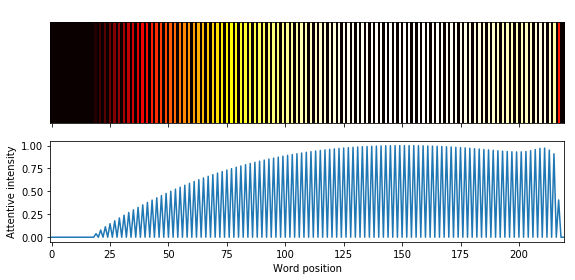

with labels 0.0
with prediction prob. [0.01479399]



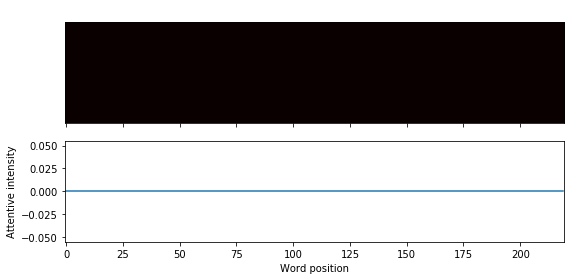

with labels 0.0
with prediction prob. [0.06544287]



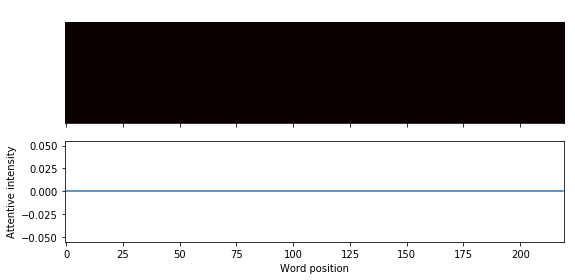

with labels 0.0
with prediction prob. [0.00214252]



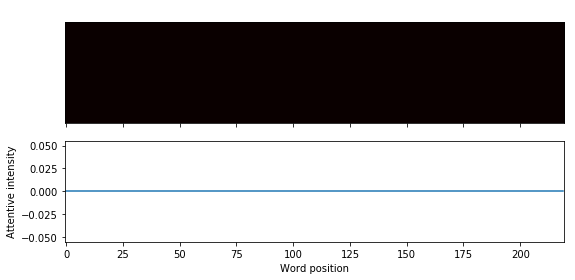

with labels 0.0
with prediction prob. [0.01920421]



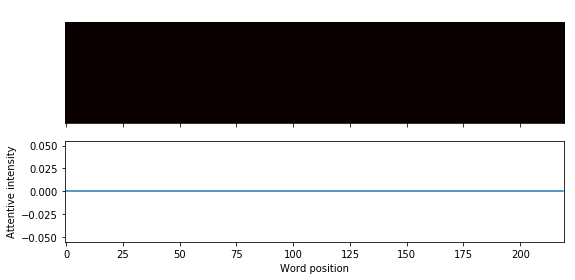

with labels 0.0
with prediction prob. [0.00136896]



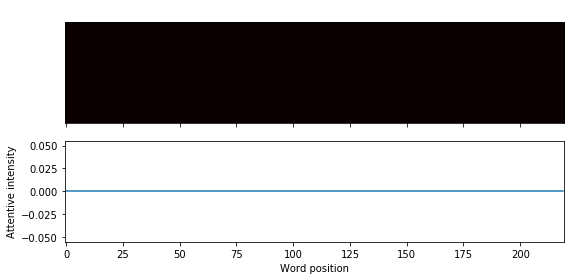

In [80]:
commt = xs[1]
tgs = ys[1]

see_results(commt, tgs, label_cols)

don ' t edit things you have no idea about ! give credit where it ' s due ! you fucking kike ! don ' t edit things you have no idea about ! give credit where it ' s due ! you fucking kike ! don ' t edit things you have no idea about ! give credit where it ' s due ! you fucking kike ! don ' t edit things you have no idea about ! give credit where it ' s due ! you fucking kike ! don ' t edit things you have no idea about ! give credit where it ' s due ! you fucking kike ! don ' t edit things you have no idea about ! give credit where it ' s due ! you fucking kike ! don ' t edit things you have no idea about ! give credit where it ' s due ! you fucking kike ! don ' t edit things you have no idea about ! give credit where it ' s due ! you fucking kike ! don ' t edit things you have no idea about ! give credit where it ' s due ! you fucking kike ! don ' t edit things you have no idea about ! give credit

with labels 1.0
with prediction prob. [0.9950205]
you fucking kike ! no idea about due 

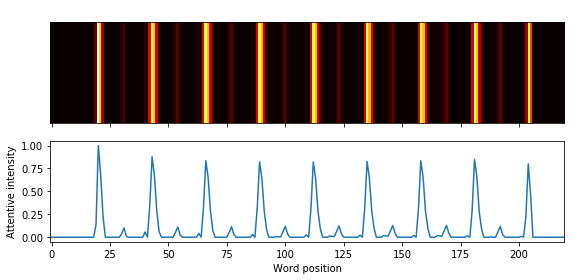

with labels 1.0
with prediction prob. [0.39702246]
fucking kike fucking kike ! fucking kike ! fucking kike ! fucking kike ! fucking kike ! fucking kike ! fucking kike ! fucking kike


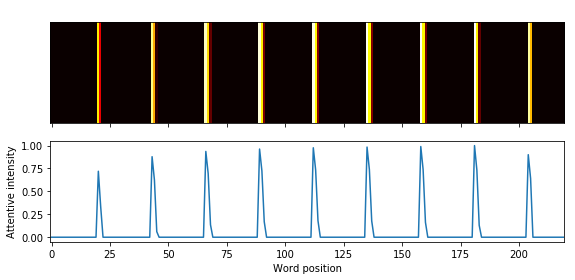

with labels 1.0
with prediction prob. [0.98757637]
fucking kike ! you fucking kike ! don you fucking kike ! don idea you fucking kike ! don ' idea you fucking kike ! don ' things idea you fucking kike ! don ' things idea you fucking kike ! don ' things idea you fucking kike ! don idea you fucking kike


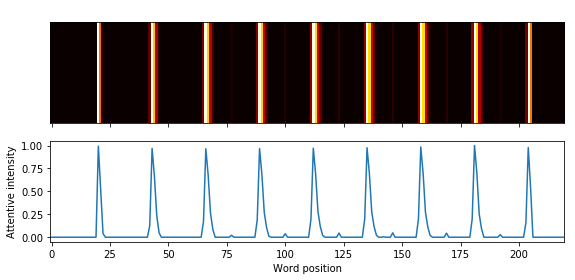

with labels 0.0
with prediction prob. [0.00602588]



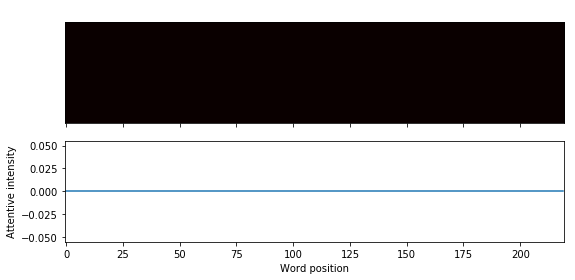

with labels 1.0
with prediction prob. [0.95119846]
fucking kike ! you fucking kike ! you fucking kike ! you fucking kike ! you fucking kike ! you fucking kike ! you fucking kike ! you fucking kike ! fucking kike


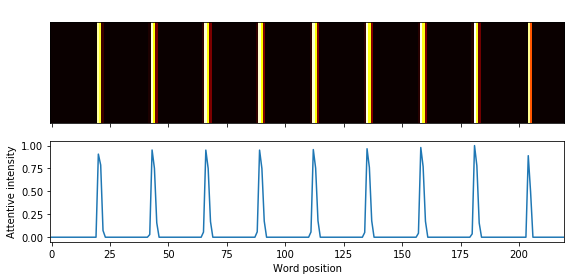

with labels 0.0
with prediction prob. [0.61173105]
kike fucking kike fucking kike fucking kike fucking kike fucking kike fucking kike fucking kike fucking kike


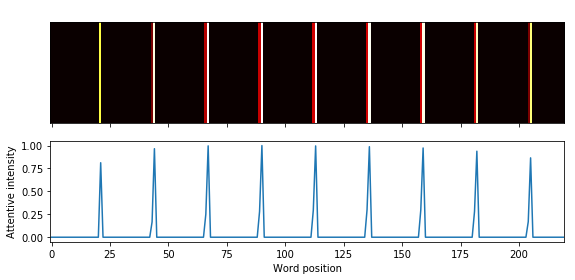

In [81]:
commt = xs[24]
tgs = ys[24]

see_results(commt, tgs, label_cols)

hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron

with labe

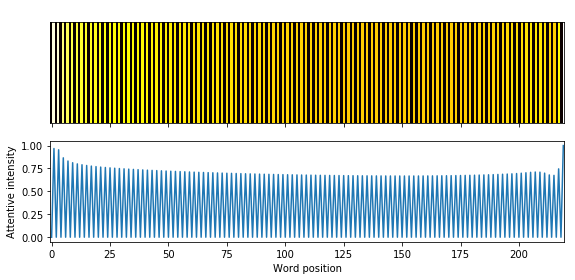

with labels 0.0
with prediction prob. [0.01368856]



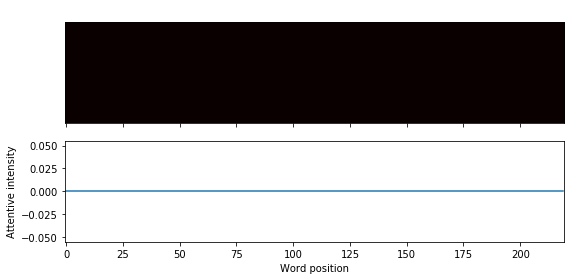

with labels 0.0
with prediction prob. [0.33322832]
moron


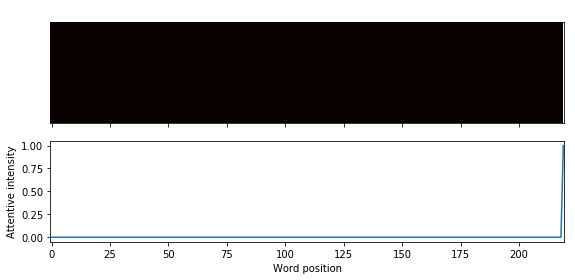

with labels 0.0
with prediction prob. [0.00039952]



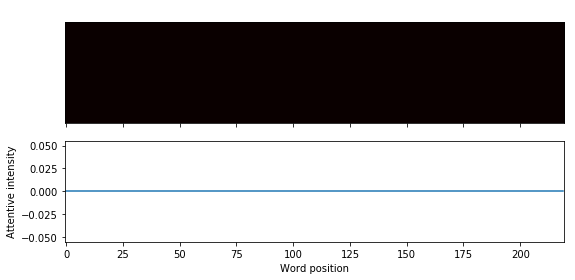

with labels 1.0
with prediction prob. [0.63643396]
moron moron moron moron moron moron moron moron moron moron moron moron moron moron moron moron


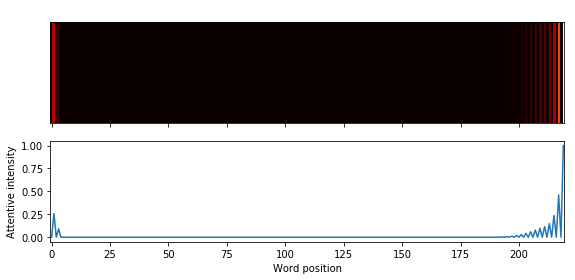

with labels 0.0
with prediction prob. [0.00500152]



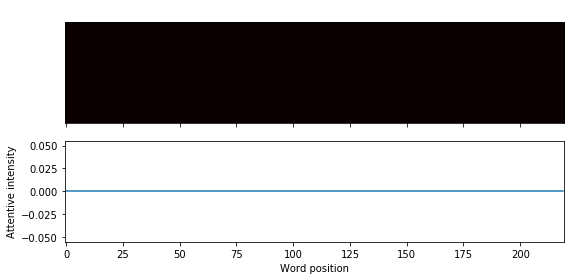

In [82]:
commt = xs[33]
tgs = ys[33]

see_results(commt, tgs, label_cols)

thank you for this article , all i need to know not to vote for her . while i agree we could use some more diverse voices running for mayor and i even liked some of her background as a potential candidate ; what we don ' t need is someone who derisively lumps all middle aged white guys together . sorry but change that wording ( and from someone else ) to " another middle aged white woman " and the candidate would get hammered for sexism , ageism , etc . . . might have been a snarky comment for humor , and that is what i want for a mayor . . . someone snarky .

with labels 0.0
with prediction prob. [0.2034413]



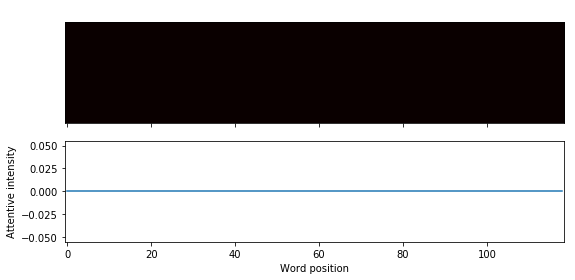

In [83]:
# labeled in unbiased dataset: 0.300000, 1.000000, 1.000000, 0.0, 0.0, 0.0, 0.0, 0.00, 1.0, 0.0
sample_str = """
Thank you for this article, all I need to know not to vote for her.   While I agree we could use some more diverse voices running for mayor and I even liked some of her background as a potential candidate; what we don't need is someone who derisively lumps all middle aged white guys together.  
Sorry but change that wording (and from someone else) to "another middle aged white woman" and the candidate would get hammered for sexism, ageism, etc...  
Might have been a snarky comment for humor, and that is what i want for a mayor...someone snarky.
"""

commt = preprocessing(sample_str)
tgs = np.array([0., 0., 0., 0., 0., 0.], dtype=np.float32)
see_results(commt[0], tgs, ['toxic'])

this is a great story . man . i wonder if the person who yelled " shut the fuck up ! " at him ever heard it .

with labels 0.0
with prediction prob. [0.8275024]
shut the fuck


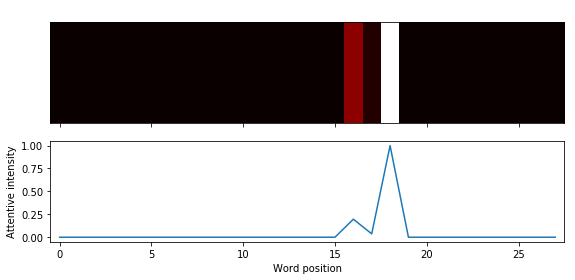

In [84]:
# labeled 0.440000, 0.600000, 0.000000, 0.0, 0.0, 0.0, 0.0, 0.00, 0.0, 0.0
sample_str = """
This is a great story. Man. I wonder if the person who yelled "shut the fuck up!" at him ever heard it.
"""

commt = preprocessing(sample_str)
tgs = np.array([0., 0., 0., 0., 0., 0.], dtype=np.float32)
see_results(commt[0], tgs, ['toxic'])

my thoughts are that people should stop being stupid and ignorant . climate change scientifically proven . it isn ' t a debate .

with labels 0.0
with prediction prob. [0.76802874]
stupid and ignorant


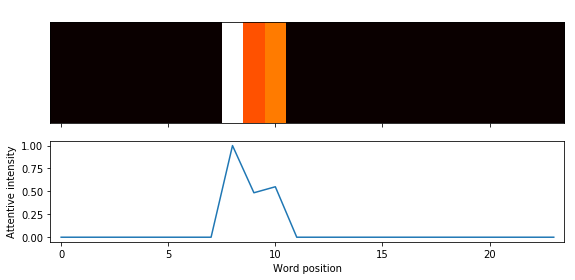

In [85]:
sample_str = """
My thoughts are that people should stop being stupid and ignorant. Climate change scientifically proven. It isn't a debate.
"""

commt = preprocessing(sample_str)
tgs = np.array([0., 0., 0., 0., 0., 0.], dtype=np.float32)
see_results(commt[0], tgs, ['toxic'])

i am a gay woman .

with labels 0.0
with prediction prob. [0.590281]
gay


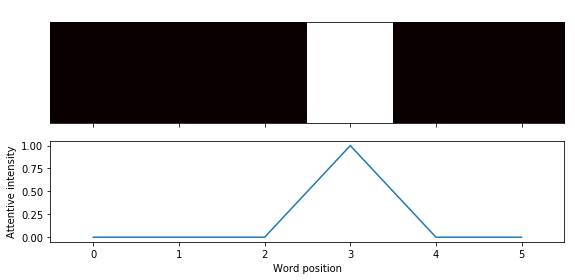

In [86]:
sample_str = """
I am a gay woman.
"""

commt = preprocessing(sample_str)
tgs = np.array([0., 0., 0., 0., 0., 0.], dtype=np.float32)
see_results(commt[0], tgs, ['toxic'])